In [31]:
import visual_behavior_glm.GLM_analysis_tools as gat
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [19]:
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


## get cached dropout summary results from mongo database

In [2]:
rs = gat.retrieve_results(search_dict = {'glm_version': '7_L2_optimize_by_session'}, results_type='summary')

In [3]:
rs.columns

Index(['_id', 'dropout', 'absolute_change_from_full', 'variance_explained',
       'variance_explained_full', 'fraction_change_from_full',
       'cell_specimen_id', 'adj_fraction_change_from_full',
       'adj_variance_explained', 'adj_variance_explained_full', 'glm_version',
       'ophys_experiment_id', 'ophys_session_id', 'entry_time_utc',
       'behavior_session_id', 'container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'session_type', 'equipment_name', 'date_of_acquisition',
       'isi_experiment_id', 'specimen_id', 'sex', 'age_in_days',
       'full_genotype', 'reporter_line', 'driver_line', 'imaging_depth',
       'targeted_structure', 'published_at', 'super_container_id', 'cre_line',
       'session_tags', 'failure_tags', 'exposure_number',
       'model_outputs_available', 'location', 'has_events', 'session_number'],
      dtype='object')

## identify all of the unique dropout names

In [4]:
dropouts = rs['dropout'].unique()

## exclude 'single' and 'image' dropouts

In [5]:
dropouts_to_use = [d for d in dropouts if not d.startswith('single') and not d.startswith('image')]
dropouts_to_use

['Full',
 'all-images',
 'behavioral',
 'change',
 'change_and_rewards',
 'cognitive',
 'correct_rejects',
 'expectation',
 'face_motion_PC_0',
 'face_motion_PC_1',
 'face_motion_PC_2',
 'face_motion_PC_3',
 'face_motion_PC_4',
 'face_motion_energy',
 'intercept',
 'misses',
 'omissions',
 'pupil',
 'pupil_and_omissions',
 'pupil_and_running',
 'running',
 'running_and_omissions',
 'task',
 'time',
 'trial_type',
 'visual',
 'beh_model',
 'hits',
 'hits_and_rewards',
 'licking',
 'licking_bouts',
 'licking_each_lick',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'rewards',
 'false_alarms']

## build a pivoted dataframe with each cell/session as a single row and 'adj_fraction_change_from_full' as the value to keep

In [6]:
rs_pivoted = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='adj_fraction_change_from_full')

In [7]:
len(rs_pivoted)

55326

## get the dominant dropout for every session/cell:

In [8]:
for idx,row in rs_pivoted.iterrows():
    rs_pivoted.at[idx,'dominant_dropout'] = rs_pivoted[dropouts_to_use].iloc[idx].abs().idxmax()
    print('idx: {}   '.format(idx), end='\r')

In [9]:
rs_pivoted.columns

Index(['identifier', 'Full', 'all-images', 'beh_model', 'behavioral', 'change',
       'change_and_rewards', 'cognitive', 'correct_rejects', 'expectation',
       ...
       'super_container_id', 'cre_line', 'session_tags', 'failure_tags',
       'exposure_number', 'model_outputs_available', 'location', 'has_events',
       'session_number', 'dominant_dropout'],
      dtype='object', length=135)

## look at value counts of dominant dropouts

In [10]:
rs_pivoted.query('dominant_dropout == "face_motion_energy"').groupby(['cre_line'])['dominant_dropout'].value_counts()

cre_line           dominant_dropout  
Slc17a7-IRES2-Cre  face_motion_energy    7
Name: dominant_dropout, dtype: int64

In [11]:
rs_pivoted.groupby(['cre_line'])['dominant_dropout'].value_counts(normalize=True)

cre_line           dominant_dropout     
Slc17a7-IRES2-Cre  visual                   0.640551
                   behavioral               0.231746
                   omissions                0.082402
                   all-images               0.027460
                   pupil_and_omissions      0.003271
                   correct_rejects          0.002527
                   cognitive                0.002145
                   pupil_and_running        0.001741
                   running_and_omissions    0.001657
                   licking                  0.001338
                   pre_lick_bouts           0.000510
                   false_alarms             0.000488
                   task                     0.000488
                   misses                   0.000382
                   post_lick_bouts          0.000361
                   time                     0.000361
                   post_licks               0.000340
                   hits                     0.000276
     

In [12]:
filepath = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/2020.10.10_dropout_summary_v7_opt_by_session.csv'
rs_pivoted.to_csv(filepath, index=False)

In [34]:
rs_pivoted.query('equipment_name != "MESO.1"').sort_values(by='face_motion_energy', ascending=True).head(60) #[['identifier','beh_model','face_motion_energy','pupil']]

,identifier,Full,all-images,beh_model,behavioral,change,change_and_rewards,cognitive,correct_rejects,expectation,face_motion_PC_0,face_motion_PC_1,face_motion_PC_2,face_motion_PC_3,face_motion_PC_4,face_motion_energy,false_alarms,hits,hits_and_rewards,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,licking,licking_bouts,licking_each_lick,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,pupil_and_omissions,pupil_and_running,rewards,running,running_and_omissions,single-all-images,single-beh_model,...,single-pre_lick_bouts,single-pre_licks,single-pupil,single-pupil_and_omissions,single-pupil_and_running,single-rewards,single-running,single-running_and_omissions,single-task,single-time,single-trial_type,single-visual,task,time,trial_type,visual,variance_explained_full,cell_specimen_id,glm_version,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,dominant_dropout
15347,869969393_962032398,0.0,0.000000,NaN,-1.000000,0.000000,0.000000,-0.003570,0.000000,0.000000,-0.182614,-0.212670,0.000000,-0.098845,0.000000,-0.922069,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.014884,0.000000,0.000000,0.000000,-0.000351,-0.037455,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.382424,NaN,-0.310770,-0.309960,0.000000,NaN,...,NaN,NaN,0.000000,0.000000,-0.094099,NaN,-0.055419,-0.053615,0.000000,0.000000,0.000000,0.000000,-0.003570,0.000000,0.000000,-0.002844,0.158529,962032398,7_L2_optimize_by_session,869969393,869118259,869303255.0,863992815.0,VisualBehavior,container_qc,passed,20190516_448900_5imagesB,OPHYS_5_images_B_passive,CAM2P.4,2019-05-16 15:49:11.000000,838753709.0,830901424.0,M,122.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,['Ai94(TITL-GCaMP6s)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175.0,VISp,NaN,830901424.0,Slc17a7-IRES2-Cre,NaN,NaN,0.0,False,Slc17a7_VISp_175,True,5.0,behavioral
30055,934476801_962534587,0.0,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.023726,-1.000000,-0.443744,0.000000,0.000000,0.000000,-0.903866,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.226103,0.000000,0.000000,0.000000,0.00000,NaN,-0.226103,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,NaN,0.000000,-0.360299,0.000000,-0.360299,-0.384036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030237,962534587,7_L2_optimize_by_session,934476801,933463604,933830753.0,928325203.0,VisualBehaviorTask1B,container_qc,passed,20190828_467951_3imagesB,OPHYS_3_images_B,CAM2P.3,2019-08-28 17:07:19.000000,888237949.0,879064141.0,M,134.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],175.0,VISp,NaN,879064141.0,Vip-IRES-Cre,NaN,NaN,0.0,True,Vip_VISp_175,True,3.0,behavioral
7254,822641265_961893111,0.0,-0.046432,NaN,-0.927326,0.000000,0.000000,-0.024731,0.000000,0.000000,-0.128447,-0.081164,-0.060417,-0.109536,-0.047224,-0.873506,NaN,NaN,NaN,0.000000,0.000000,-0.126030,-0.345765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-0.005486,NaN,NaN,NaN,NaN,-0.005270,NaN,NaN,NaN,NaN,NaN,-0.005270,-0.022019,NaN,-0.022019,-0.022019,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.024731,-0.091635,0.000000,-0.048878,0.087498,961893111,7_L2_optimize_by_session,822641265,822081744,822249041.0,803516615.0,Visua

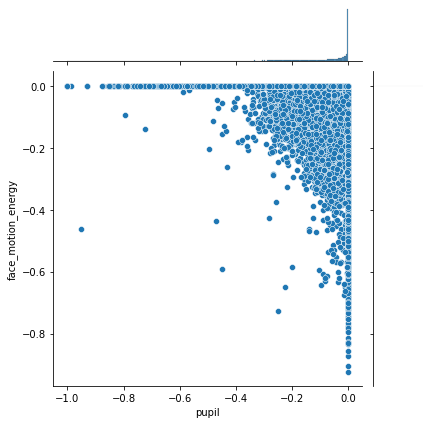

In [35]:
sns.jointplot(
    data= rs_pivoted.query('equipment_name != "MESO.1" and variance_explained_full > 0.01').fillna(0),
    x='pupil',
    y='face_motion_energy',
)